<a href="https://colab.research.google.com/github/arezaie9331/HOI_Datasets/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# V-CoCo Dataset

In [2]:
!mkdir data
!mkdir data/v-coco

In [3]:
cd data/v-coco

/content/data/v-coco


## Download Official Files

In [4]:
!wget http://images.cocodataset.org/zips/train2014.zip
!wget http://images.cocodataset.org/zips/val2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip

--2025-05-07 11:54:00--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.228.249, 54.231.164.185, 3.5.29.136, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.228.249|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘train2014.zip’

train2014.zip       100%[===================>]  12.58G  71.8MB/s    in 14m 14s 

2025-05-07 12:08:14 (15.1 MB/s) - ‘train2014.zip’ saved [13510573713/13510573713]

--2025-05-07 12:08:14--  http://images.cocodataset.org/zips/val2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.164.1, 3.5.20.65, 16.15.217.18, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.164.1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645013297 (6.2G) [application/zip]
Saving to: ‘val2014.zip’

val2014.zip         100%[===================>]   6.19

## Extracting datas

In [5]:
!unzip train2014.zip
!rm train2014.zip
!unzip val2014.zip
!rm val2014.zip
!unzip annotations_trainval2014.zip
!rm annotations_trainval2014.zip

Streaming output truncated to the last 5000 lines.
 extracting: val2014/COCO_val2014_000000191304.jpg  
 extracting: val2014/COCO_val2014_000000171062.jpg  
 extracting: val2014/COCO_val2014_000000014549.jpg  
 extracting: val2014/COCO_val2014_000000121152.jpg  
 extracting: val2014/COCO_val2014_000000276596.jpg  
 extracting: val2014/COCO_val2014_000000029431.jpg  
 extracting: val2014/COCO_val2014_000000036349.jpg  
 extracting: val2014/COCO_val2014_000000502055.jpg  
 extracting: val2014/COCO_val2014_000000438848.jpg  
 extracting: val2014/COCO_val2014_000000364973.jpg  
 extracting: val2014/COCO_val2014_000000564166.jpg  
 extracting: val2014/COCO_val2014_000000323327.jpg  
 extracting: val2014/COCO_val2014_000000338581.jpg  
 extracting: val2014/COCO_val2014_000000039656.jpg  
 extracting: val2014/COCO_val2014_000000071667.jpg  
 extracting: val2014/COCO_val2014_000000376046.jpg  
 extracting: val2014/COCO_val2014_000000066394.jpg  
 extracting: val2014/COCO_val2014_000000277584.j

## Getting Other annotations

In [11]:
cd annotations

/content/data/v-coco/annotations


In [15]:
!gdown 1_Vz2IWADlqFU-KXC6YTBxhw2KbAJasoC

Downloading...
From (original): https://drive.google.com/uc?id=1_Vz2IWADlqFU-KXC6YTBxhw2KbAJasoC
From (redirected): https://drive.google.com/uc?id=1_Vz2IWADlqFU-KXC6YTBxhw2KbAJasoC&confirm=t&uuid=cbb0be88-1f26-4714-b167-010365482b42
To: /content/data/v-coco/annotations/trainval_vcoco.json
100% 5.00M/5.00M [00:00<00:00, 42.4MB/s]


In [16]:
!gdown 1qUxa3369hR9FJACwcSArbT6g5PGs45mK

Downloading...
From: https://drive.google.com/uc?id=1qUxa3369hR9FJACwcSArbT6g5PGs45mK
To: /content/data/v-coco/annotations/test_vcoco.json
100% 4.51M/4.51M [00:00<00:00, 35.4MB/s]


## Define dataset in torch

In [18]:
cd ../../../

/content


In [35]:
import os
import json
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as T

class VCOCOHOIDataset(Dataset):
    def __init__(self, vcoco_json_path, image_dir, transform=None):
        # Load the list of data items (one per image)
        with open(vcoco_json_path, 'r') as f:
            self.data = json.load(f)  # This is a list, not a dict

        self.image_dir = image_dir
        self.transform = transform if transform else T.ToTensor()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_path = os.path.join(self.image_dir, item["file_name"])
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # Get bounding boxes and category_ids
        boxes = [ann["bbox"] for ann in item["annotations"]]
        labels = [ann["category_id"] for ann in item["annotations"]]

        # HOI annotations
        hoi = item.get("hoi_annotation", [])  # optional

        # HOI triplets: (subject box, object box, interaction category)
        hoi_triplets = []
        for h in hoi:
            subj_box = item["annotations"][h["subject_id"]]["bbox"]
            obj_box = item["annotations"][h["object_id"]]["bbox"] if h["object_id"] != -1 else None
            hoi_triplets.append({
                "subject_bbox": subj_box,
                "object_bbox": obj_box,
                "interaction": h["category_id"]
            })

        return {
            "image": image,
            "boxes": boxes,
            "labels": labels,
            "hoi_triplets": hoi_triplets,
            "file_name": item["file_name"]
        }


In [46]:
transform = T.Compose([
    # T.Resize((512, 512)),
    T.ToTensor()
])

dataset = VCOCOHOIDataset(
    vcoco_json_path="data/v-coco/annotations/trainval_vcoco.json",
    image_dir="data/v-coco/train2014",
    transform=transform
)

dataset_val = VCOCOHOIDataset(
    vcoco_json_path="data/v-coco/annotations/test_vcoco.json",
    image_dir="data/v-coco/val2014",
    transform=transform
)


In [47]:
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import ImageDraw
import torch

def visualize_sample(sample, label_map=None):
    # Convert tensor to PIL image if needed
    image_tensor = sample["image"]
    if isinstance(image_tensor, torch.Tensor):
        image = TF.to_pil_image(image_tensor)
    else:
        image = image_tensor.copy()

    draw = ImageDraw.Draw(image)

    boxes = sample["boxes"]
    labels = sample["labels"]

    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = box
        draw.rectangle([x1, y1, x2, y2], outline="red", width=3)

        label_name = label_map[label] if label_map else str(label)
        draw.text((x1, y1), label_name, fill="white")

    plt.imshow(image)
    plt.axis("off")
    plt.title(sample["file_name"])
    plt.show()


In [48]:
sample = dataset[0]
print(sample["file_name"])
print(sample["hoi_triplets"])

COCO_train2014_000000226162.jpg
[{'subject_bbox': [154.49, 71.25, 312.81, 395.57], 'object_bbox': [35.3, 143.39, 390.89, 245.51], 'interaction': 0}, {'subject_bbox': [154.49, 71.25, 312.81, 395.57], 'object_bbox': None, 'interaction': 1}, {'subject_bbox': [154.49, 71.25, 312.81, 395.57], 'object_bbox': None, 'interaction': 4}, {'subject_bbox': [154.49, 71.25, 312.81, 395.57], 'object_bbox': None, 'interaction': 5}, {'subject_bbox': [154.49, 71.25, 312.81, 395.57], 'object_bbox': [35.3, 143.39, 390.89, 245.51], 'interaction': 13}]


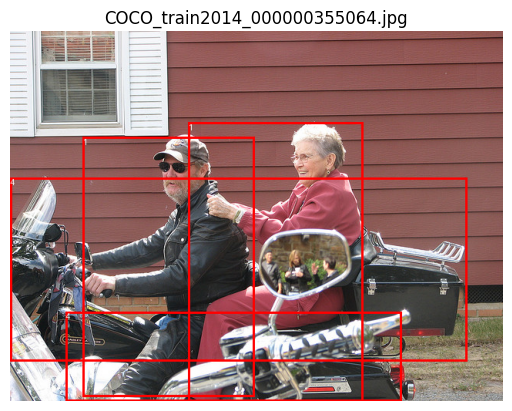

In [49]:
visualize_sample(dataset[100])

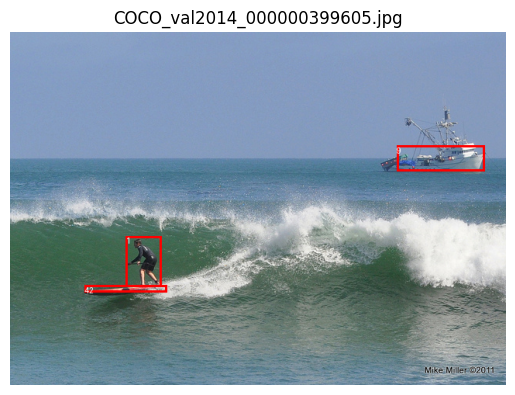

In [51]:
visualize_sample(dataset_val[101])

In [52]:
len(dataset)+len(dataset_val)

10346